In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2DTranspose, Conv2D, Input, BatchNormalization, Activation, concatenate, Layer
)
import os
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt

C:\Users\Tanma\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = ''
image_path = os.path.join(path, 'data/images/')
mask_path = os.path.join(path, 'data/panoptic/')
image_list_orig = os.listdir(image_path)
mask_list_orig = os.listdir(mask_path)
image_list = [os.path.join(image_path, i) for i in image_list_orig if i.endswith('.jpg')][:100]
mask_list = [os.path.join(mask_path, i) for i in mask_list_orig if i.endswith('.png')][:100]

test_image_path = os.path.join(path, 'val_cityscapes/img/')
test_image_list_orig = os.listdir(test_image_path)
test_image_list = [test_image_path+i for i in test_image_list_orig if i.endswith('.png')]


In [3]:
def process_test_path(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (96, 128))
    return img

# Preprocess testing data
test_image_filenames = tf.constant(test_image_list)

# Convert to TensorFlow Dataset
test_image_ds = tf.data.Dataset.from_tensor_slices(test_image_filenames)

# Apply preprocessing function to the dataset
test_image_ds = test_image_ds.map(process_test_path)


C:\Users\Tanma\AppData\Local\Temp\ipykernel_20176\1645610153.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\Tanma\AppData\Local\Temp\ipykernel_20176\1645610153.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

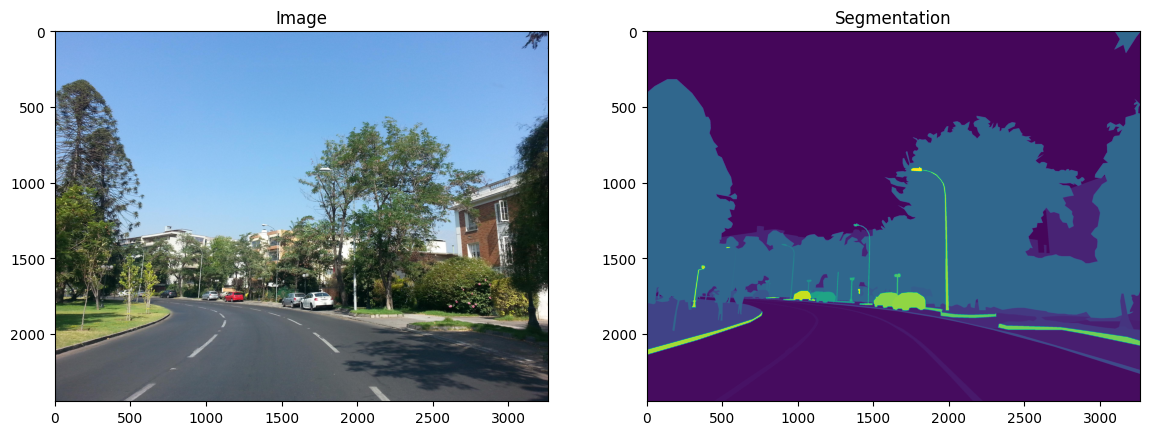

In [4]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--NSVcUgfVhFd6uzkqHOOg.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--NSVcUgfVhFd6uzkqHOOg.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--SWG8TJo7vrbZ_x5YLj6A.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--SWG8TJo7vrbZ_x5YLj6A.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--WOpVBuHlCygAUADkttpg.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--WOpVBuHlCygAUADkttpg.png'>)


In [6]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

test_filenames = tf.constant(test_image_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))


for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'data/images/--jRsD9anHdGxv4ZOCQktA.jpg', shape=(), dtype=string)
tf.Tensor(b'data/panoptic/--jRsD9anHdGxv4ZOCQktA.png', shape=(), dtype=string)


In [7]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
num_classes = 256
def preprocess_labels(dataset, num_classes):
    def map_labels(image, label):
        label = tf.clip_by_value(label, 0, num_classes - 1)  # Clip to valid range
        return image, label
    return dataset.map(map_labels)

processed_image_ds = preprocess_labels(processed_image_ds, num_classes)

In [8]:
class ResizeLayer(Layer):
    def __init__(self, target_shape, **kwargs):
        super().__init__(**kwargs)
        self.target_shape = target_shape

    def call(self, x):
        return tf.image.resize(x, self.target_shape)

def build_vgg16_segmentation(input_shape=(96, 128, 3), num_classes=256):
    """
    Build a semantic segmentation model using VGG16 as the encoder.
    Args:
        input_shape: Tuple, the shape of the input image.
        num_classes: Integer, the number of segmentation classes.
    Returns:
        A TensorFlow Keras Model for segmentation.
    """
    # Load pretrained VGG16 without the fully connected layers
    vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    
    inputs = vgg16.input
    print(f"Input shape: {inputs.shape}")
    
    # Encoder (VGG16)
    encoder_outputs = [
        vgg16.get_layer("block1_pool").output,  # 1/2 resolution
        vgg16.get_layer("block2_pool").output,  # 1/4 resolution
        vgg16.get_layer("block3_pool").output,  # 1/8 resolution
        vgg16.get_layer("block4_pool").output,  # 1/16 resolution
        vgg16.get_layer("block5_pool").output,  # 1/32 resolution
    ]
    
    # Print encoder output shapes
    for i, output in enumerate(encoder_outputs):
        print(f"Encoder block {i+1} output shape: {output.shape}")
    
    # Decoder
    x = encoder_outputs[-1]
    print(f"\nDecoder starting shape: {x.shape}")
    
    # First upsampling block (1/32 -> 1/16)
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same")(x)
    print(f"After first upsampling: {x.shape}")
    print(f"Skip connection shape: {encoder_outputs[3].shape}")
    if x.shape[1:3] != encoder_outputs[3].shape[1:3]:
        print(f"Warning: Shape mismatch at first skip connection")
        x = ResizeLayer(target_shape=encoder_outputs[3].shape[1:3])(x)
    x = concatenate([x, encoder_outputs[3]])
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    print(f"After first concatenation and activation: {x.shape}")
    
    # Second upsampling block (1/16 -> 1/8)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(x)
    print(f"After second upsampling: {x.shape}")
    print(f"Skip connection shape: {encoder_outputs[2].shape}")
    if x.shape[1:3] != encoder_outputs[2].shape[1:3]:
        print(f"Warning: Shape mismatch at second skip connection")
        x = ResizeLayer(target_shape=encoder_outputs[2].shape[1:3])(x)
    x = concatenate([x, encoder_outputs[2]])
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    print(f"After second concatenation and activation: {x.shape}")
    
    # Third upsampling block (1/8 -> 1/4)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(x)
    print(f"After third upsampling: {x.shape}")
    print(f"Skip connection shape: {encoder_outputs[1].shape}")
    if x.shape[1:3] != encoder_outputs[1].shape[1:3]:
        print(f"Warning: Shape mismatch at third skip connection")
        x = ResizeLayer(target_shape=encoder_outputs[1].shape[1:3])(x)
    x = concatenate([x, encoder_outputs[1]])
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    print(f"After third concatenation and activation: {x.shape}")
    
    # Fourth upsampling block (1/4 -> 1/2)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(x)
    print(f"After fourth upsampling: {x.shape}")
    print(f"Skip connection shape: {encoder_outputs[0].shape}")
    if x.shape[1:3] != encoder_outputs[0].shape[1:3]:
        print(f"Warning: Shape mismatch at fourth skip connection")
        x = ResizeLayer(target_shape=encoder_outputs[0].shape[1:3])(x)
    x = concatenate([x, encoder_outputs[0]])
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    print(f"After fourth concatenation and activation: {x.shape}")
    
    # Final upsampling to original image size (1/2 -> 1)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(x)
    if x.shape[1:3] != input_shape[:2]:
        print(f"Warning: Shape mismatch at final layer")
        x = ResizeLayer(target_shape=input_shape[:2])(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    print(f"After final upsampling: {x.shape}")
    
    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation="sigmoid")(x)
    print(f"Final output shape: {outputs.shape}")
    
    # Create the model
    model = Model(inputs=vgg16.input, outputs=outputs)
    return model

In [9]:
input_shape = (96, 128, 3)
num_classes = 256
model = build_vgg16_segmentation(input_shape=input_shape, num_classes=num_classes)

Input shape: (None, 96, 128, 3)
Encoder block 1 output shape: (None, 48, 64, 64)
Encoder block 2 output shape: (None, 24, 32, 128)
Encoder block 3 output shape: (None, 12, 16, 256)
Encoder block 4 output shape: (None, 6, 8, 512)
Encoder block 5 output shape: (None, 3, 4, 512)

Decoder starting shape: (None, 3, 4, 512)
After first upsampling: (None, 6, 8, 512)
Skip connection shape: (None, 6, 8, 512)
After first concatenation and activation: (None, 6, 8, 1024)
After second upsampling: (None, 12, 16, 256)
Skip connection shape: (None, 12, 16, 256)
After second concatenation and activation: (None, 12, 16, 512)
After third upsampling: (None, 24, 32, 128)
Skip connection shape: (None, 24, 32, 128)
After third concatenation and activation: (None, 24, 32, 256)
After fourth upsampling: (None, 48, 64, 64)
Skip connection shape: (None, 48, 64, 64)
After fourth concatenation and activation: (None, 48, 64, 128)
After final upsampling: (None, 96, 128, 64)
Final output shape: (None, 96, 128, 256)


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 96, 128, 3)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 96, 128, 64)       │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 96, 128, 64)       │          36,928 │ block1_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool (MaxPooling2D)    │ (None, 48, 64, 64)        │               0 │ block1_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 48, 64, 128)       │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 48, 64, 128)       │         147,584 │ block2_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 24, 32, 128)       │               0 │ block2_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv1 (Conv2D)         │ (None, 24, 32, 256)       │         295,168 │ block2_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv2 (Conv2D)         │ (None, 24, 32, 256)       │         590,080 │ block3_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv3 (Conv2D)         │ (None, 24, 32, 256)       │         590,080 │ block3_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_pool (MaxPooling2D)    │ (None, 12, 16, 256)       │               0 │ block3_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv1 (Conv2D)         │ (None, 12, 16, 512)       │       1,180,160 │ block3_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv2 (Conv2D)         │ (None, 12, 16, 512)       │       2,359,808 │ block4_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv3 (Conv2D)         │ (None, 12, 16, 512)       │       2,359,808 │ block4_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_pool (MaxPooling2D)    │ (None, 6, 8, 512)         │               0 │ block4_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv1 (Conv2D)         │ (None, 6, 8, 512)         │       2,359,808 │ block4_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv2 (Conv2D)         │ (None, 6, 8, 512)         │       2,359,808 │ block5_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 20,269,888 (77.32 MB)

 Trainable params: 20,265,920 (77.31 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [11]:
def pixel_accuracy(y_true, y_pred):
    # Convert predicted probabilities to predicted labels
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    # Ensure y_pred_labels has the same shape as y_true
    y_pred_labels = tf.reshape(y_pred_labels, tf.shape(y_true))
    # Cast y_true to the same data type as y_pred_labels
    y_true = tf.cast(y_true, y_pred_labels.dtype)
    # Compare predicted labels to true labels and compute accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    return accuracy




def mean_iou(y_true, y_pred):
    # Convert predicted probabilities to predicted labels
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    # Ensure y_pred_labels has the same shape as y_true
    y_pred_labels = tf.reshape(y_pred_labels, tf.shape(y_true))
    # Compute IoU for each class
    iou = []
    for i in range(1, 124):  # Excluding background class 0
        intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred_labels, i)), tf.float32))
        union = tf.reduce_sum(tf.cast(tf.logical_or(tf.equal(y_true, i), tf.equal(y_pred_labels, i)), tf.float32))
        iou.append((intersection + 1e-7) / (union + 1e-7))  # Add small epsilon to avoid division by zero
    # Compute mean IoU across classes
    mean_iou = tf.reduce_mean(iou)
    return mean_iou


def precision(y_true, y_pred):
    """
    Compute Precision for segmentation.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        Precision as a scalar.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)  # Convert logits to class labels
    
    # Remove the extra dimension in y_true if it exists
    y_true = tf.squeeze(y_true, axis=-1)  # Shape (batch_size, height, width)
    
    # Ensure consistency in data types (cast both to int64)
    y_true = tf.cast(y_true, tf.int64)
    y_pred_labels = tf.cast(y_pred_labels, tf.int64)

    # Exclude background class (0)
    true_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    predicted_positive = tf.reduce_sum(tf.cast(tf.not_equal(y_pred_labels, 0), tf.float32))
    
    return true_positive / (predicted_positive + 1e-7)  # Avoid division by zero

def recall(y_true, y_pred):
    """
    Compute Recall.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        Recall as a scalar.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    
    # Remove the extra dimension in y_true if it exists
    y_true = tf.squeeze(y_true, axis=-1)
    
    # Ensure consistency in data types (cast both to int64)
    y_true = tf.cast(y_true, tf.int64)
    y_pred_labels = tf.cast(y_pred_labels, tf.int64)

    true_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    actual_positive = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.float32))  # Exclude background
    return true_positive / (actual_positive + 1e-7)  # Avoid division by zero


def f1_score(y_true, y_pred):
    """
    Compute F1 Score for segmentation.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        F1 Score as a scalar.
    """
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    
    return 2 * (precision_value * recall_value) / (precision_value + recall_value + 1e-7)



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= [pixel_accuracy, precision, recall])

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(3024, 4032, 1)


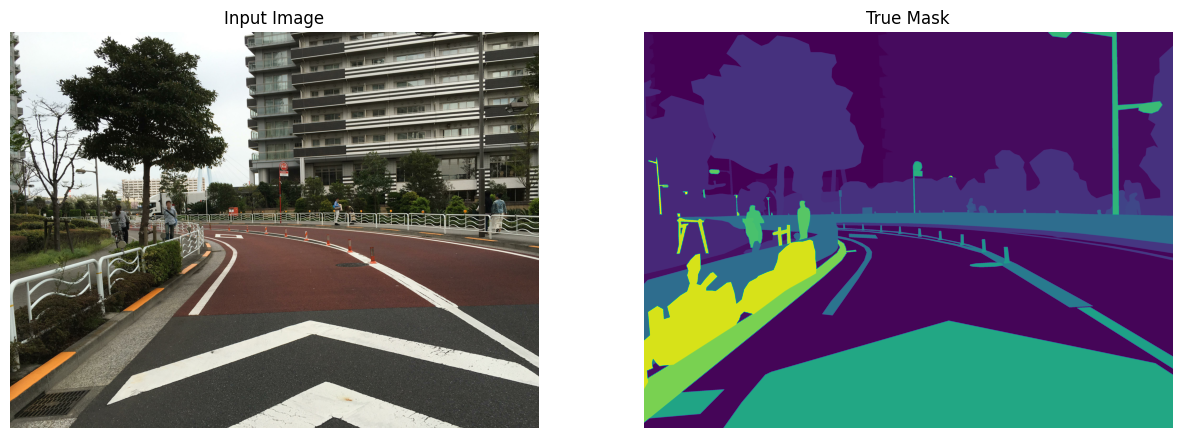

In [13]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


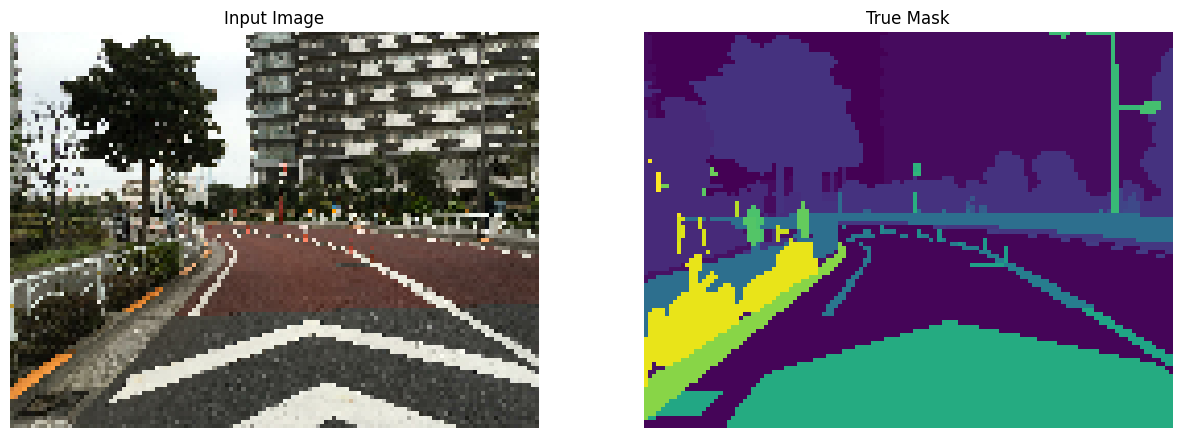

In [14]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [15]:
EPOCHS =150
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 4
train_dataset = (
    processed_image_ds
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Check the dataset structure
print(train_dataset.element_spec)

# Train the model
model_history = model.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(None, 96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/150


C:\Users\Tanma\AppData\Roaming\Python\Python310\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 651ms/step - loss: 5.0559 - pixel_accuracy: 0.2009 - precision: 0.2009 - recall: 0.2011
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 595ms/step - loss: 3.7798 - pixel_accuracy: 0.3763 - precision: 0.3763 - recall: 0.3766
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 598ms/step - loss: 3.2307 - pixel_accuracy: 0.3960 - precision: 0.3960 - recall: 0.3964
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 614ms/step - loss: 2.9810 - pixel_accuracy: 0.3955 - precision: 0.3955 - recall: 0.3959
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 582ms/step - loss: 2.8610 - pixel_accuracy: 0.4028 - precision: 0.4028 - recall: 0.4032
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 580ms/step - loss: 2.8037 - pixel_accuracy: 0.4067 - precision: 0.4067 - recall: 0.4070
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 594ms/step - loss: 2.7767 - pixel_accuracy: 0.4058 - precision: 0.4058 - recall: 0.4062
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 612ms/step - loss: 2.7462 - pixel_accuracy: 0.4089 -

In [16]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [18]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


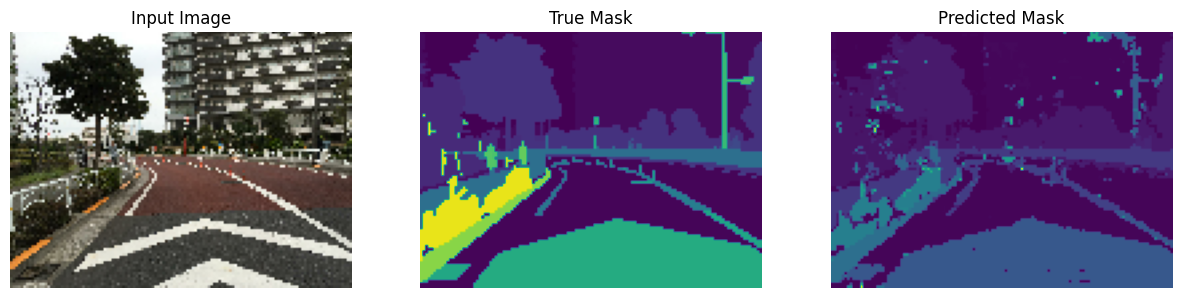

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


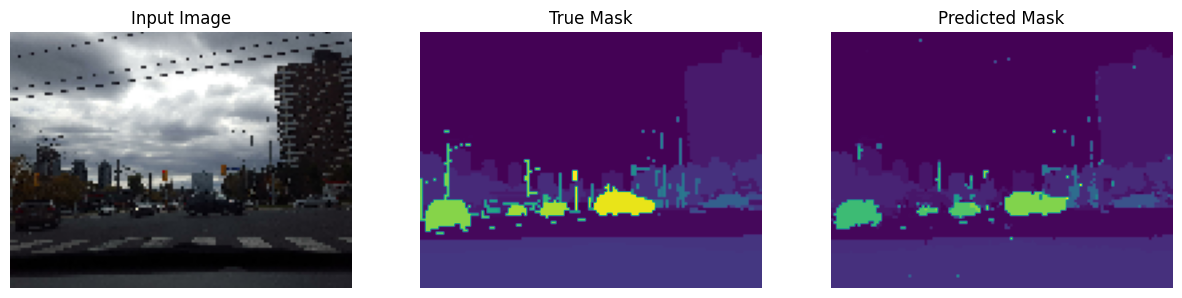

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


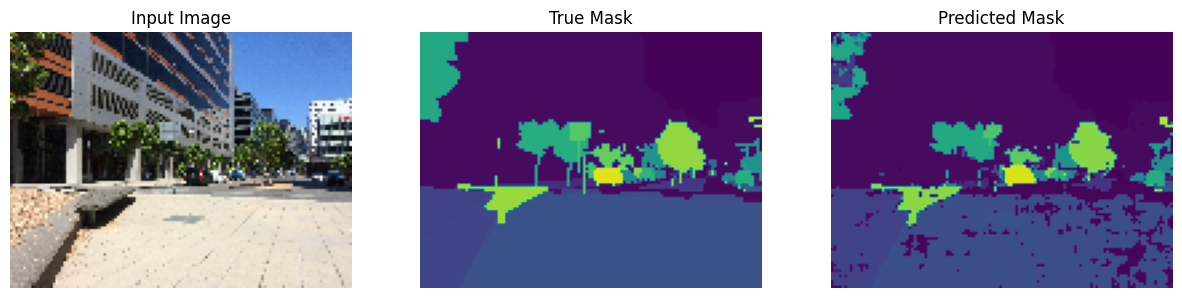

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


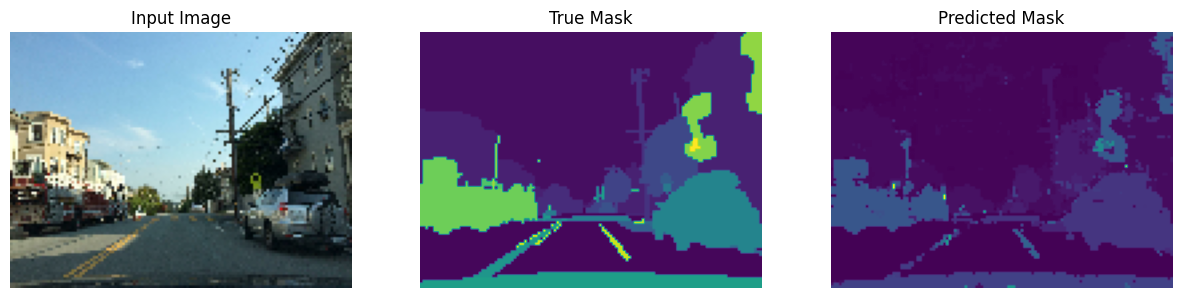

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


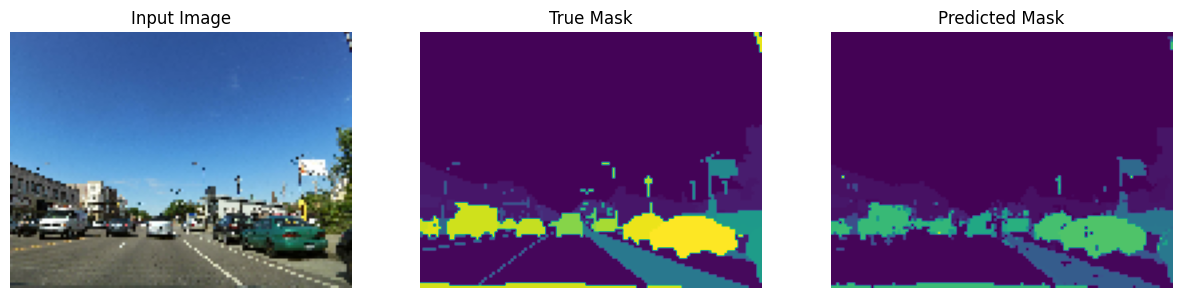

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


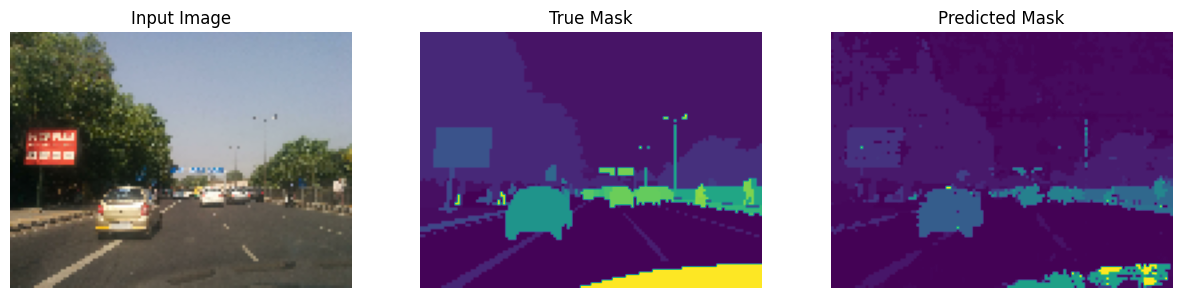

In [19]:
show_predictions(train_dataset, 6)

In [ ]:
def preprocess_test(image):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    return input_image

In [ ]:

import os
import cv2  # Assuming you're using OpenCV to load images
import numpy as np
import tensorflow as tf

# Assuming test_masks_folder contains the ground truth masks
test_masks_folder = "test_masks"

# Load ground truth masks
true_masks = []
for image_path in test_image_list:
    mask_path = os.path.join(test_masks_folder, os.path.basename(image_path))
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_masks.append(true_mask)

# Make predictions using the trained model
pred_masks = []
for test_image in test_image_ds.take(len(test_image_list)):
    test_image = test_image[tf.newaxis, ...]
    pred_mask = model.predict(test_image)
    pred_masks.append(pred_mask)

def create_rgb_mask(mask):
    """
    Converts a single-channel mask to a three-channel RGB mask
    """
    return cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

def convert_mask_color(mask, color_scheme):
    """
    Converts a mask's color scheme according to the given color_scheme dictionary
    """
    converted_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)  # Create an empty RGB mask
    for value in color_scheme:
        converted_mask[mask == value] = color_scheme[value]
    return converted_mask

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def show_test_predictions(test_images_preprocessed, pred_masks, true_masks, num=1):
    """
    Displays the first num images of the test set along with predicted and ground truth masks
    """
    cmap = plt.cm.viridis  # Use the 'viridis' colormap

    for i, (test_image, pred_mask, true_mask) in enumerate(zip(test_images_preprocessed, pred_masks, true_masks)):
        if i >= num:
            break
        
        display_list = [test_image, create_mask(pred_mask), true_mask]
        title = ['Test Image', 'Predicted Mask', 'True Mask']
        display(display_list, title, cmap)

def display(display_list, title=None, cmap=None):
    """
    Displays a list of images with their corresponding titles
    """
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if cmap is not None and i == len(display_list) - 1:  # Apply colormap only to the last image
            plt.imshow(display_list[i], cmap=cmap)
        else:
            plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

# Display predictions for the test set along with ground truth
show_test_predictions(test_image_ds, pred_masks, true_masks, num=17)

